In [73]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Infinite Relational Model
# via 石井健一郎・上田修功 "続・わかりやすいパターン認識" Chapter 14

# This code is available under the MIT License.
# (c)2016 Nakatani Shuyo / Cybozu Labs Inc.

import numpy
from scipy.special import betaln, gammaln

def log_ps(a, n, N):
    c = len(n)
    return c * numpy.log(a) + gammaln(n).sum() - gammaln(a + N) + gammaln(a) - gammaln(c+1)

class IRM(object):
    def __init__(self, data, alpha, a, b):
        self.R = data
        self.N1, self.N2 = data.shape 
        
        #hyper parametr
        self.alpha = alpha
        self.a = a
        self.b = b
        
        #各データのクラスタ割当
        self.z1 = numpy.zeros(self.N1, dtype=int) - 1
        self.z2 = numpy.zeros(self.N2, dtype=int) - 1
        
        #各クラスタが含む数
        self.n1 = []
        self.n2 = []

    def update(self):
        #第一ドメインのサンプリング
        for idx1 in range(self.N1):
            p = self.update_cluster(idx1, self.z1, self.z2, self.n1, self.n2, self.R)
        #第二ドメインのサンプリング
        for idx2 in range(self.N2):
            p = self.update_cluster(idx2, self.z2, self.z1, self.n2, self.n1, self.R.T)

    def update_cluster(self, idx, z1, z2, n1, n2, R):
        
        #減算処理
        now_i = z1[idx]
        z1[idx] = -1
        if now_i >= 0:
            n1[now_i] -= 1
            if n1[now_i] == 0:
                n1.pop(now_i)
                z1[z1>now_i] -= 1
        
        #十分統計量の算出
        c1 = len(n1)
        c2 = len(n2)
        m1, m0, m1k, m0k = self.count_nij(R, z1, z2, c1, c2)


        #sampingのための条件付き確率
        logps = numpy.zeros(c1+1)
        for i in range(c1):
            p = numpy.log(n1[i])
            p += self.logZ(self.a+m1[i]+m1k, self.b+m0[i]+m0k).sum()
            p -= self.logZ(self.a+m1[i], self.b+m0[i]).sum()
            logps[i] = p
        p = numpy.log(self.alpha)
        p += self.logZ(self.a+m1k, self.b+m0k).sum()
        p -= c2 * self.logZ(self.a, self.b)
        p -=  self.logZ(self.a, self.b)
        logps[c1] = p

        logps -= logps.max()
        ps = numpy.exp(logps)
        ps /= ps.sum()
        new_i = numpy.random.choice(c1+1, 1, p=ps)[0]
        
        #加算処理
        #既存テーブル
        if new_i<c1:
            n1[new_i] += 1
        #new テーブル
        else:
            n1.append(1)
        z1[idx] = new_i

    def log_posterior(self):
        log_v = log_ps(self.alpha, self.n1, self.N1)
        log_v += log_ps(self.alpha, self.n2, self.N2)
        m1, m0, m1k, m0k = self.count_nij(self.R, self.z1, self.z2, len(self.n1), len(self.n2))
        beta_ab = self.logZ(self.a, self.b)
        for m1i, m0i in zip(m1, m0):
            for n1, n0 in zip(m1i, m0i):
                log_v += self.logZ(n1 + self.a, n0 + self.b) - beta_ab
        return log_v

    def clone(self):
        import copy
        return copy.deepcopy(self)

    def logZ(self, a, b):
        "Log Normalization Constant of Beta Distribution"
        return betaln(a, b)

    def count_nij(self, R, z1, z2, c1, c2):
        m1 = numpy.zeros((c1,c2), dtype=int)    # n_(-k,+)[i,j]
        m0 = numpy.zeros((c1,c2), dtype=int)    # n~
        m1k = numpy.zeros(c2, dtype=int)        # n_(k,+)[j] where s_k=ω_i
        m0k = numpy.zeros(c2, dtype=int)        # n~
        for i, rk in zip(z1, R):
            if i>=0:
                m1i = m1[i]
                m0i = m0[i]
            else:
                m1i = m1k
                m0i = m0k
            for j, r in zip(z2, rk):
                if j<0: continue
                m1i[j] += r
                m0i[j] += 1-r
        return m1, m0, m1k, m0k


* 生成過程
$$ Z_{1}|\alpha_{1} \sim CRP(\alpha_1)\\
   Z_{2}|\alpha_{2} \sim CRP(\alpha_2)\\
   \theta_{k,l}|a_{0},b_{0} \sim Beta(a_{0},b_{0})\\
   x_{i,j}|\{\theta_{k,l}\},z_{1,i},z_{2,j} \sim Beronoulli(\theta_{z_{1,i},z_{2,j}})
$$ 

In [100]:
from numpy.random import binomial
from numpy import concatenate as concat

numpy.random.seed(123)
d = 10
phi = [[0.0, 1.0, 0.0, 0.0,0.0], 
       [0.0, 0.0, 0.0, 1.0,0.0], 
       [1.0, 0.0, 0.0, 0.0,0.0],
       [0.0, 0.0, 1.0, 0.0,0.0],
       [0.0, 0.0, 0.0, 0.0,1.0]]
orgR = concat([concat([binomial(1, p, size=(d,d)) for p in pp], axis=1) for pp in phi])
i = numpy.arange(orgR.shape[0])
numpy.random.shuffle(i)
R = orgR[i,:]
i = numpy.arange(orgR.shape[1])
numpy.random.shuffle(i)
R = R[:,i]

model = IRM(R, alpha=1.0, a=1.0, b=1.0)
maxv = -1e9
for i in range(100):
    model.update()
    v = model.log_posterior()
    if v > maxv:
        maxv = v
        maxm = model.clone()
    print(i, v)
RR = R[numpy.argsort(maxm.z1), :]
RR = RR[:, numpy.argsort(maxm.z2)]
print("--------")
print(orgR)

print(R)

print(maxm.z1)
print(maxm.z2)

print(RR)

print(maxv)

0 -1300.8859047099609
1 -1297.3564441705184
2 -1300.1322091682946
3 -1292.9551500664932
4 -1292.9551500664932
5 -1301.2705818240681
6 -1300.9771958767255
7 -1301.2705818240681
8 -1298.931766075926
9 -1296.4197869620298
10 -1298.931766075926
11 -1301.4794109595364
12 -1296.385129352289
13 -1002.5551849424542
14 -979.4212557928262
15 -979.4212557928262
16 -979.4212557928262
17 -979.4212557928262
18 -979.4212557928262
19 -979.4212557928262
20 -979.4212557928262
21 -979.4212557928262
22 -979.4212557928262
23 -988.619215519035
24 -979.4212557928262
25 -979.4212557928262
26 -979.4212557928262
27 -979.4212557928262
28 -979.4212557928262
29 -979.4212557928262
30 -979.4212557928262
31 -979.4212557928262
32 -979.4212557928262
33 -979.4212557928262
34 -979.4212557928262
35 -979.4212557928262
36 -979.4212557928262
37 -979.4212557928262
38 -979.4212557928262
39 -979.4212557928262
40 -979.4212557928262
41 -979.4212557928262
42 -979.4212557928262
43 -979.4212557928262
44 -979.4212557928262
45 -979.42

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
    
def draw_heatmap(data,maxm):
    # 描画する
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    c1 = Counter(maxm.z1)
    c2 = Counter(maxm.z2)
    print(c1)

    cnt1 = c1[0]
    for idx in range(len(c1)-1):
        ax.axhline(cnt1, c="grey")
        cnt1 += c1[idx+1]

    cnt2 = c2[0]
    for idx in range(len(c2)):
        ax.axvline(cnt2, c="grey")
        cnt2 += c2[idx+1]    

    #ax.set_xticklabels(row_labels, minor=False)
    #ax.set_yticklabels(column_labels, minor=False)
    plt.show()
    #plt.savefig('image.png')

    return heatmap

Counter({0: 40, 1: 10})


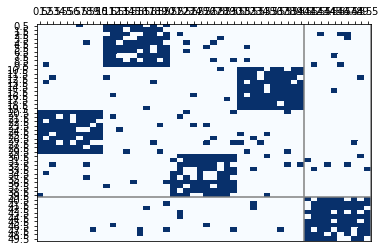

Counter({0: 40, 1: 10})


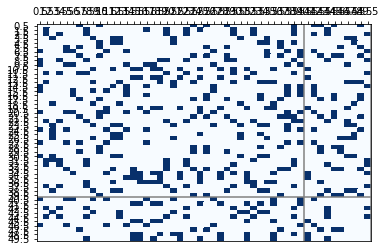

Counter({0: 40, 1: 10})


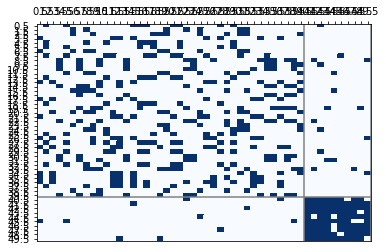

In [99]:
draw_heatmap(orgR,maxm)
draw_heatmap(R,maxm)
draw_heatmap(RR,maxm)

In [66]:
print(numpy.sort(maxm.s1))
print(numpy.sort(maxm.s2))

[0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
